# Compute regridding weights and write to file

Requires esmpy-7.1.0.dev38 at https://anaconda.org/NESII/esmpy/files. Can be installed by

    conda install -c nesii/label/dev-esmf -c conda-forge esmpy==7.1.0.dev38

This notebook also includes the timing of applying weights with ESMPy. For the timing of applying weights with pure Python, see [apply_weights.ipynb](apply_weights.ipynb) .

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import ESMF
import xesmf as xe

## Make input and output grids

In [2]:
ds_in = xe.grid_2d(-120, 120, 0.4,
                   -60, 60, 0.3)
ds_in

<xarray.Dataset>
Dimensions:  (x: 600, x_b: 601, y: 400, y_b: 401)
Coordinates:
    lon      (y, x) float64 -119.8 -119.4 -119.0 -118.6 -118.2 -117.8 -117.4 ...
    lat      (y, x) float64 -59.85 -59.85 -59.85 -59.85 -59.85 -59.85 -59.85 ...
    lon_b    (y_b, x_b) float64 -120.0 -119.6 -119.2 -118.8 -118.4 -118.0 ...
    lat_b    (y_b, x_b) float64 -60.0 -60.0 -60.0 -60.0 -60.0 -60.0 -60.0 ...
Dimensions without coordinates: x, x_b, y, y_b
Data variables:
    *empty*

In [3]:
ds_out = xe.grid_2d(-120, 120, 0.6,
                    -60, 60, 0.4)
ds_out

<xarray.Dataset>
Dimensions:  (x: 400, x_b: 401, y: 300, y_b: 301)
Coordinates:
    lon      (y, x) float64 -119.7 -119.1 -118.5 -117.9 -117.3 -116.7 -116.1 ...
    lat      (y, x) float64 -59.8 -59.8 -59.8 -59.8 -59.8 -59.8 -59.8 -59.8 ...
    lon_b    (y_b, x_b) float64 -120.0 -119.4 -118.8 -118.2 -117.6 -117.0 ...
    lat_b    (y_b, x_b) float64 -60.0 -60.0 -60.0 -60.0 -60.0 -60.0 -60.0 ...
Dimensions without coordinates: x, x_b, y, y_b
Data variables:
    *empty*

## Create ESMPy grid object

In [4]:
sourcegrid = xe.highlevel._ds_to_ESMFgrid(ds_in)
destgrid = xe.highlevel._ds_to_ESMFgrid(ds_out)

## Create ESMPy field object

In [5]:
# to test broadcasting across extra dimensions
extra_dims = [10, 50]  
sourcefield = ESMF.Field(sourcegrid, ndbounds=extra_dims)
destfield = ESMF.Field(destgrid, ndbounds=extra_dims)

# ESMPy stacks extra dimensions to the right
sourcefield.data.shape, destfield.data.shape

((400, 600, 10, 50), (300, 400, 10, 50))

## Compute regridding weights and write to file

In [6]:
# rm weights.nc # ESMPy will complain if the weight file already exists

In [7]:
%%time
# extra dimensions affect this online regridding object `regrid`, 
# but has no effect on the offline weight file
regrid = ESMF.Regrid(sourcefield, destfield, #filename='weights.nc',
                     regrid_method = ESMF.RegridMethod.BILINEAR,
                     unmapped_action = ESMF.UnmappedAction.IGNORE)

CPU times: user 10.6 s, sys: 70 ms, total: 10.7 s
Wall time: 10.7 s


## Create input data field for testing

In [8]:
Nlat_in, Nlon_in, Ntime, Nlev = sourcefield.data.shape
Nlat_in, Nlon_in, Ntime, Nlev

(400, 600, 10, 50)

In [9]:
# add time and level coordinates
ds_in.coords['time'] = np.arange(1, Ntime+1)
ds_in.coords['lev'] = np.arange(1, Nlev+1)
ds_in

<xarray.Dataset>
Dimensions:  (lev: 50, time: 10, x: 600, x_b: 601, y: 400, y_b: 401)
Coordinates:
    lon      (y, x) float64 -119.8 -119.4 -119.0 -118.6 -118.2 -117.8 -117.4 ...
    lat      (y, x) float64 -59.85 -59.85 -59.85 -59.85 -59.85 -59.85 -59.85 ...
    lon_b    (y_b, x_b) float64 -120.0 -119.6 -119.2 -118.8 -118.4 -118.0 ...
    lat_b    (y_b, x_b) float64 -60.0 -60.0 -60.0 -60.0 -60.0 -60.0 -60.0 ...
  * time     (time) int64 1 2 3 4 5 6 7 8 9 10
  * lev      (lev) int64 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
Dimensions without coordinates: x, x_b, y, y_b
Data variables:
    *empty*

In [10]:
# Make a 4D data field.

# wave-like 2D field 
wave = lambda x,k:  np.sin(x*k*np.pi/180.0)
wave2d = 1.0 + wave(ds_in['lon'], 4) * wave(ds_in['lat'], 3)

# let it increases linearly with time and lev to test broadcasting
ds_in['data'] = wave2d * ds_in['time'] * ds_in['lev'] 
ds_in

<xarray.Dataset>
Dimensions:  (lev: 50, time: 10, x: 600, x_b: 601, y: 400, y_b: 401)
Coordinates:
    lon      (y, x) float64 -119.8 -119.4 -119.0 -118.6 -118.2 -117.8 -117.4 ...
    lat      (y, x) float64 -59.85 -59.85 -59.85 -59.85 -59.85 -59.85 -59.85 ...
    lon_b    (y_b, x_b) float64 -120.0 -119.6 -119.2 -118.8 -118.4 -118.0 ...
    lat_b    (y_b, x_b) float64 -60.0 -60.0 -60.0 -60.0 -60.0 -60.0 -60.0 ...
  * time     (time) int64 1 2 3 4 5 6 7 8 9 10
  * lev      (lev) int64 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
Dimensions without coordinates: x, x_b, y, y_b
Data variables:
    data     (y, x, time, lev) float64 1.007 2.014 3.021 4.027 5.034 6.041 ...

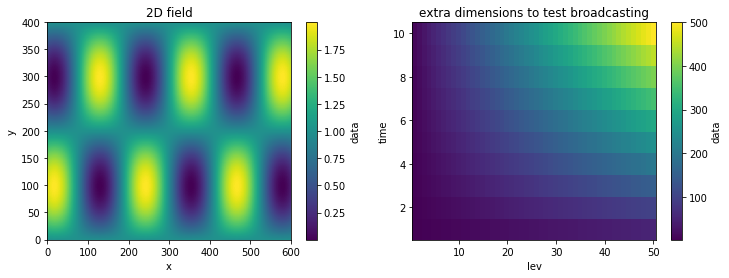

In [11]:
plt.figure(figsize=[12,4])
plt.subplot(121);ds_in['data'].isel(time=0, lev=0).plot()
plt.title('2D field')
plt.subplot(122);ds_in['data'].mean(dim=['x','y']).plot()
plt.title('extra dimensions to test broadcasting')


## Use ESMPy to apply regrid weights (call underlying Fortran routine)

### Tweak array ordering

Numpy array are typically C-ordered:

In [12]:
ds_in['data'].values.flags

  C_CONTIGUOUS : True
  F_CONTIGUOUS : False
  OWNDATA : True
  WRITEABLE : True
  ALIGNED : True
  UPDATEIFCOPY : False

But ESMPy uses Fortran-ordering

In [13]:
sourcefield.data.flags

  C_CONTIGUOUS : False
  F_CONTIGUOUS : True
  OWNDATA : False
  WRITEABLE : True
  ALIGNED : True
  UPDATEIFCOPY : False

This makes transfering data very slow

In [14]:
# transfer data to ESMPy internal
%time sourcefield.data[...] = ds_in['data'].values

CPU times: user 5.9 s, sys: 550 ms, total: 6.45 s
Wall time: 6.47 s


The time is spent on transforming the memory layout:

In [15]:
%time testcopy = np.asfortranarray(ds_in['data'].values)

CPU times: user 5.79 s, sys: 540 ms, total: 6.33 s
Wall time: 6.34 s


In [16]:
testcopy.flags

  C_CONTIGUOUS : False
  F_CONTIGUOUS : True
  OWNDATA : True
  WRITEABLE : True
  ALIGNED : True
  UPDATEIFCOPY : False

Passing Fortran-ordered array is fast

In [17]:
# transfer data to ESMPy internal
%time sourcefield.data[...] = testcopy

CPU times: user 150 ms, sys: 0 ns, total: 150 ms
Wall time: 153 ms


### Apply regridding

In [18]:
destfield.data.max() # destination field is 0 before regridding

0.0

In [19]:
# apply regridding weights
%time destfield = regrid(sourcefield, destfield)

CPU times: user 1.24 s, sys: 340 ms, total: 1.58 s
Wall time: 1.58 s


In [20]:
destfield.data.shape

(300, 400, 10, 50)

In [21]:
# add into DataSet so it is easier to plot
ds_out.coords['time'] = ds_in['time']
ds_out.coords['lev'] = ds_in['lev']
ds_out['data'] = (('y', 'x', 'time', 'lev'), destfield.data)
ds_out

<xarray.Dataset>
Dimensions:  (lev: 50, time: 10, x: 400, x_b: 401, y: 300, y_b: 301)
Coordinates:
    lon      (y, x) float64 -119.7 -119.1 -118.5 -117.9 -117.3 -116.7 -116.1 ...
    lat      (y, x) float64 -59.8 -59.8 -59.8 -59.8 -59.8 -59.8 -59.8 -59.8 ...
    lon_b    (y_b, x_b) float64 -120.0 -119.4 -118.8 -118.2 -117.6 -117.0 ...
    lat_b    (y_b, x_b) float64 -60.0 -60.0 -60.0 -60.0 -60.0 -60.0 -60.0 ...
  * time     (time) int64 1 2 3 4 5 6 7 8 9 10
  * lev      (lev) int64 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
Dimensions without coordinates: x, x_b, y, y_b
Data variables:
    data     (y, x, time, lev) float64 1.009 2.018 3.028 4.037 5.046 6.055 ...

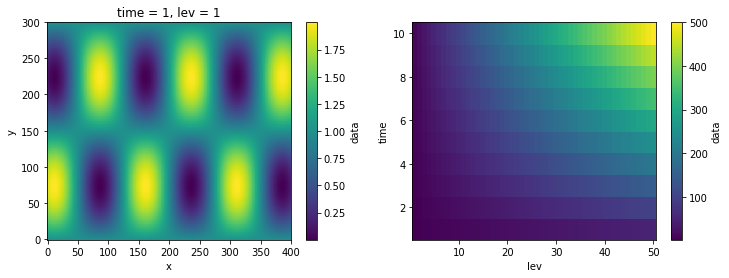

In [22]:
# both 2D regridding and broadcasting are working correctly
plt.figure(figsize=[12,4])
plt.subplot(121);ds_out['data'].isel(time=0, lev=0).plot()
plt.subplot(122);ds_out['data'].mean(dim=['x','y']).plot()

# Write input and output data to file

In [23]:
ds_in.to_netcdf('input_data.nc')
ds_out.to_netcdf('output_data.nc')